# Lab 10

INDEX:
-  starting point (lab in class)
-  lab10 implementation: 2 players + RL
-  further analysis
-  Q learning

## starting point (lab in class)

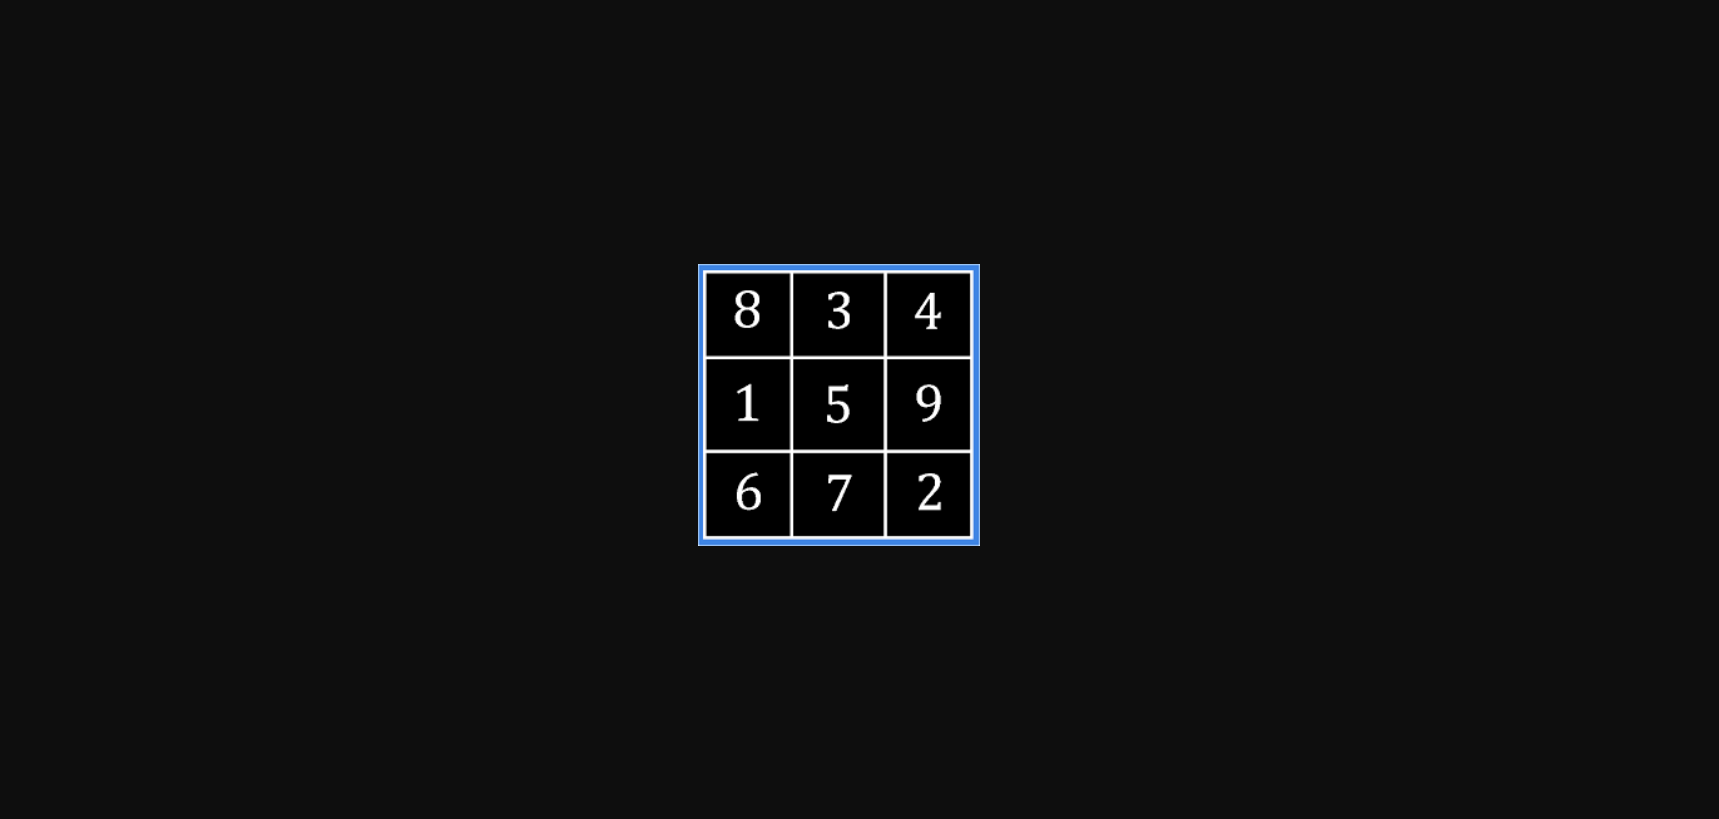

In [1]:
from random import choice
# let's play tic tac toe with the magic square knowledge background
import numpy as np
from itertools import combinations
from collections import namedtuple, defaultdict
from copy import deepcopy
from tqdm.auto import tqdm

MAGIC = [2, 7, 6,
         9, 5, 1,
         4, 3, 8]

State = namedtuple('State', ['x', 'o'])

def win(elements):
    # check if the elements are winning
    # if any of the combinations of 3 numbers taken randomly from 1 to 9 is equal to 15
    return any(sum(c) == 15 for c in combinations(elements, 3))

def state_value(pos: State):
    # evaluate state: +1 first player wins
    if win(pos.x):
      return 1
    elif win(pos.o):
      return -1
    else:
      return 0

def print_board(pos):
    for row in range(3):
      for column in range(3):
        i = row * 3 + column
        if MAGIC[i] in pos.x:
          print('x', end='')
        if MAGIC[i] in pos.o:
          print('o', end='')
        else:
          print('_', end='')
      print()
    print()


In [2]:
def random_game():
    trajectory = list()
    state = State(set(), set())
    available = set(range(1, 9+1))

    while available:
      x = choice(list(available))
      state.x.add(x)
      trajectory.append(deepcopy(state))
      available.remove(x)
      if win(state.x) or not available:
        break


      o = choice(list(available))
      state.o.add(o)
      trajectory.append(deepcopy(state))
      available.remove(o)
      if win(state.o):
        break

    return trajectory

# main loop
value_dictionary = defaultdict(float)
hit_state = defaultdict(int)
epsilon = .001

for steps in tqdm(range(1000)):
  trajectory = random_game()
  final_reward = state_value(trajectory[-1])
  # it's a cumulative sum
  for state in trajectory:
    hashable_state = (frozenset(state.x), frozenset(state.o))
    hit_state[hashable_state] += 1 # times of the moves
    value_dictionary[hashable_state] = value_dictionary[hashable_state] + epsilon*(final_reward - value_dictionary[hashable_state])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [3]:
sorted(hit_state.items(), key = lambda e: e[1], reverse = True)[:10]

[((frozenset({5}), frozenset()), 121),
 ((frozenset({7}), frozenset()), 118),
 ((frozenset({1}), frozenset()), 114),
 ((frozenset({4}), frozenset()), 114),
 ((frozenset({6}), frozenset()), 112),
 ((frozenset({8}), frozenset()), 109),
 ((frozenset({9}), frozenset()), 107),
 ((frozenset({2}), frozenset()), 104),
 ((frozenset({3}), frozenset()), 101),
 ((frozenset({6}), frozenset({2})), 28)]

In [4]:
len(hit_state)

3195

## lab10 implementation: 2 players + RL

x ---> 1

o ---> 0

In [ ]:
import random
# let's play tic tac toe with the magic square knowledge background
import numpy as np
from itertools import combinations
from collections import namedtuple, defaultdict
from copy import deepcopy
from tqdm.auto import tqdm

State = namedtuple('State', ['x', 'o'])

MAGIC = [2, 7, 6,
         9, 5, 1,
         4, 3, 8]

def win(elements):
  # check if the elements are winning
  # if any of the combinations of 3 numbers taken randomly from 1 to 9 is equal to 15
  return any(sum(c) == 15 for c in combinations(elements, 3))

def state_value(pos: State):
  # evaluate state: +1 first player wins
  if win(pos.x):
    return 1
  elif win(pos.o):
    return 0
  else:
    return -1

def print_board(pos):
  for row in range(3):
    for column in range(3):
      i = row * 3 + column
      if MAGIC[i] in pos.x:
        print('x', end='')
      if MAGIC[i] in pos.o:
        print('o', end='')
      else:
        print('_', end='')
    print()
  print()


In the init function, we keep track of all positions the player’s been taken during each game in a list self.states and update the corresponding states in self.states_value dict. In terms of choosing action, we use ϵ-greedy method to balance between exploration and exploitation. Here we set exp_rate=0.3 , which means ϵ=0.3 , so 70% of the time our agent will take greedy action, which is choosing action based on current estimation of states-value, and 30% of the time our agent will take random action.

(https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542)

See also below that I set `epsilon = .003`.

In [ ]:
class Agent:
  def __init__(self, x_or_o):
    self.x_or_o = x_or_o
    self.wins = 0
    self.value_dictionary = defaultdict(float)
    initial_lr = 0.2
    self.lr = initial_lr
    self.decay_gamma = 0.9

  def do_it_random(self, available, state):
    move = random.choice(list(available))
    current_state = deepcopy(state)
    current_state.x.add(move)
    # if (frozenset(state.x), frozenset(state.o)) not in self.value_dictionary.keys():
    self.value_dictionary[(frozenset(state.x), frozenset(state.o))] = epsilon
    return move

  def move(self, available, state):
    best_move = None
    if random.uniform(0, 1) <= epsilon:
      # do a random move
      move = self.do_it_random(available, state)
      best_move = move

    else:
      # if self.value_dictionary is not None:
        max_value = -999 # - infinite
        for move in available:
          current_state = deepcopy(state)
          current_state.x.add(move)
          hashable_state = (frozenset(state.x), frozenset(state.o))
          if hashable_state in self.value_dictionary.keys():
            value = self.value_dictionary[hashable_state]
            if value >= max_value:
              max_value = value
              best_move = move
        if best_move is None:
          move = self.do_it_random(available, state)
          best_move = move
      # else:
      #   move = self.do_it_random(self, available, state)
      #   best_move = move


    return best_move

  def return_lr(self, state, reward):
    hashable_state = (frozenset(state.x), frozenset(state.o))
    self.value_dictionary[hashable_state] += self.lr * (self.decay_gamma * reward - self.value_dictionary[hashable_state])
    r = self.value_dictionary[hashable_state]
    self.lr *= self.decay_gamma
    return self.lr

  def feedReward(self, state, reward):
    hashable_state = (frozenset(state.x), frozenset(state.o))
    self.value_dictionary[hashable_state] += self.lr * (self.decay_gamma * reward - self.value_dictionary[hashable_state])
    r = self.value_dictionary[hashable_state]
    return r

In [ ]:
class RandomPlayer:
  def __init__(self, x_or_o):
    self.x_or_o = x_or_o
    self.wins = 0
    self.value_dictionary = defaultdict(float)
    self.lr = 0.1
    self.decay_gamma = 0.9

  def move(self, available, state = None):
    return random.choice(list(available))

  def feedReward(self, state, reward):
    hashable_state = (frozenset(state.x), frozenset(state.o))
    self.value_dictionary[hashable_state] += self.lr * (self.decay_gamma * reward - self.value_dictionary[hashable_state])
    r = self.value_dictionary[hashable_state]
    return r

In [ ]:
def game(player1, player2):
  trajectory = list()
  state = State(set(), set())
  available = set(range(1, 9+1))

  players = [player1, player2]
  first_player = random.choice([0, 1])
  while available:
    current_player = players[first_player]

    move = current_player.move(list(available), state)

    # x = random.choice(list(available))
    if current_player.x_or_o == 1: # move = put a x
      state.x.add(move)
      trajectory.append(deepcopy(state))
      available.remove(move)
      if win(state.x) or not available:
        # current_player.wins += 1
        player2.wins += 1
        break

    else: # move = put a o
      # o = random.choice(list(available))
      state.o.add(move)
      trajectory.append(deepcopy(state))
      available.remove(move)
      if win(state.o):
        # current_player.wins += 1
        player1.wins += 1
        break

    first_player = 1 - first_player # if player 0 started, now it's the turn of player 1

  return trajectory


def give_reward(state, player1, player2):
  # result = win(state.x)
  if win(state.x): # x won
    player1.feedReward(state, 1)
    fr = player2.feedReward(state, -0.5)
  elif win(state.o): # o won
    player1.feedReward(state, -0.5)
    fr =  player2.feedReward(state, 1)
  else: # nobody won
    player1.feedReward(state, 0.1)
    fr = player2.feedReward(state, 0.1)
  return fr


In [ ]:
# main loop

hit_state = defaultdict(int)
epsilon = .003

player1 = RandomPlayer(0) # o
player2 = Agent(1) # x

matches = 10_000

win_percentages = []
lrs = []
rew = None
for steps in tqdm(range(matches)):
  trajectory = game(player1, player2)
  reward = give_reward((trajectory[-1]), player1, player2)
  rew = reward

  for state in trajectory:
    hashable_state = (frozenset(state.x), frozenset(state.o))
    hit_state[hashable_state] += 1 # times of the moves
    lr = player2.return_lr(state, rew)
    lrs.append(lr)

  win_percentages.append(player2.wins/matches*100)
print(f'The clever agent wins {player2.wins/matches*100}% times')

  0%|          | 0/10000 [00:00<?, ?it/s]

The clever agent wins 45.440000000000005% times


_______________

## further analyses

In [ ]:
# main loop
# value_dictionary = defaultdict(float)
hit_state = defaultdict(int)
# epsilon = .003
epsilons = [0.0007, 0.009, 0.006, 0.003, 0.01, 0.05]

for epsilon in epsilons:
  print(f'WORKING WITH epsilon = {epsilon}')
  player1 = RandomPlayer(0) # o
  player2 = Agent(1) # x

  matches = 10_000
  win_percentages = []
  lrs = []
  rew = None
  for steps in tqdm(range(matches)):
    trajectory = game(player1, player2)
    reward = give_reward((trajectory[-1]), player1, player2)
    rew = reward

    for state in trajectory:
      hashable_state = (frozenset(state.x), frozenset(state.o))
      hit_state[hashable_state] += 1 # times of the moves
      lr = player2.return_lr(state, rew)
      lrs.append(lr)

      # reward = give_reward((trajectory[-1]), player1, player2)
      # if reward:
      #   player1.feedReward(reward)
      #   player2.feedReward(reward)
    win_percentages.append(player2.wins/matches*100)
  print(f'The clever agent wins {player2.wins/matches*100}% times')
  win_percentages.clear()

WORKING WITH epsilon = 0.0007


  0%|          | 0/10000 [00:00<?, ?it/s]

The clever agent wins 45.11% times
WORKING WITH epsilon = 0.009


  0%|          | 0/10000 [00:00<?, ?it/s]

The clever agent wins 46.0% times
WORKING WITH epsilon = 0.006


  0%|          | 0/10000 [00:00<?, ?it/s]

The clever agent wins 45.33% times
WORKING WITH epsilon = 0.003


  0%|          | 0/10000 [00:00<?, ?it/s]

The clever agent wins 45.190000000000005% times
WORKING WITH epsilon = 0.01


  0%|          | 0/10000 [00:00<?, ?it/s]

The clever agent wins 45.53% times
WORKING WITH epsilon = 0.05


  0%|          | 0/10000 [00:00<?, ?it/s]

The clever agent wins 45.78% times


_________________

In [ ]:
len(hit_state)

4016

In [ ]:
sorted(hit_state.items(), key = lambda e: e[1], reverse = True)[:10]

[((frozenset({9}), frozenset()), 29794),
 ((frozenset({9}), frozenset({4})), 7381),
 ((frozenset({9}), frozenset({7})), 7050),
 ((frozenset({9}), frozenset({2})), 7004),
 ((frozenset({9}), frozenset({3})), 6998),
 ((frozenset({9}), frozenset({8})), 6927),
 ((frozenset({9}), frozenset({6})), 6895),
 ((frozenset({9}), frozenset({1})), 6888),
 ((frozenset({9}), frozenset({5})), 6804),
 ((frozenset({8, 9}), frozenset({4})), 3895)]

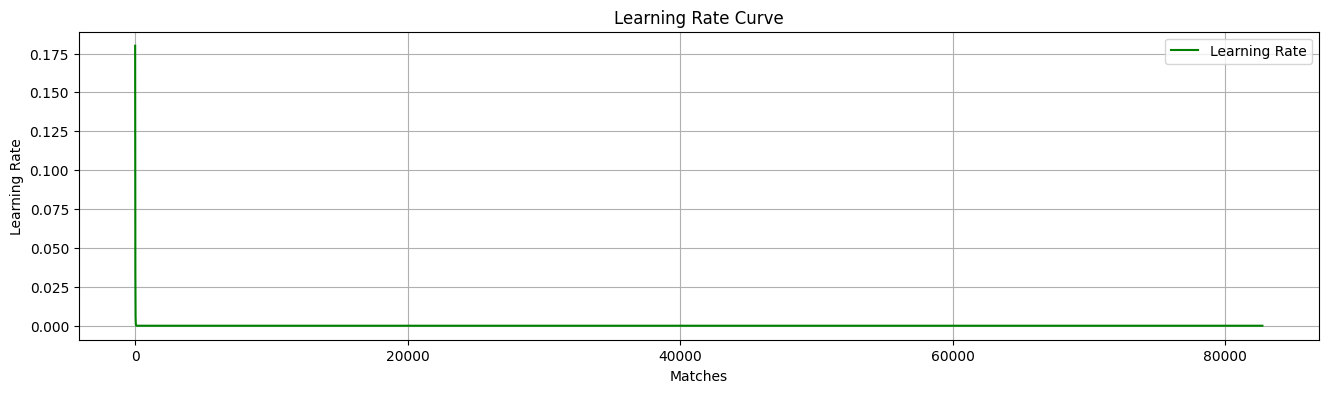

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_rate(learning_rates, title="Learning Rate Curve", xlabel="Matches", ylabel="Learning Rate"):
    """
    Plot the learning rate over time.

    Parameters:
    - learning_rates (list): List of learning rates over time.
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    """
    matches = list(range(1, len(learning_rates) + 1))

    plt.figure(figsize=(16, 4))
    plt.plot(matches, learning_rates, label='Learning Rate', color='g')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_rate(lrs)

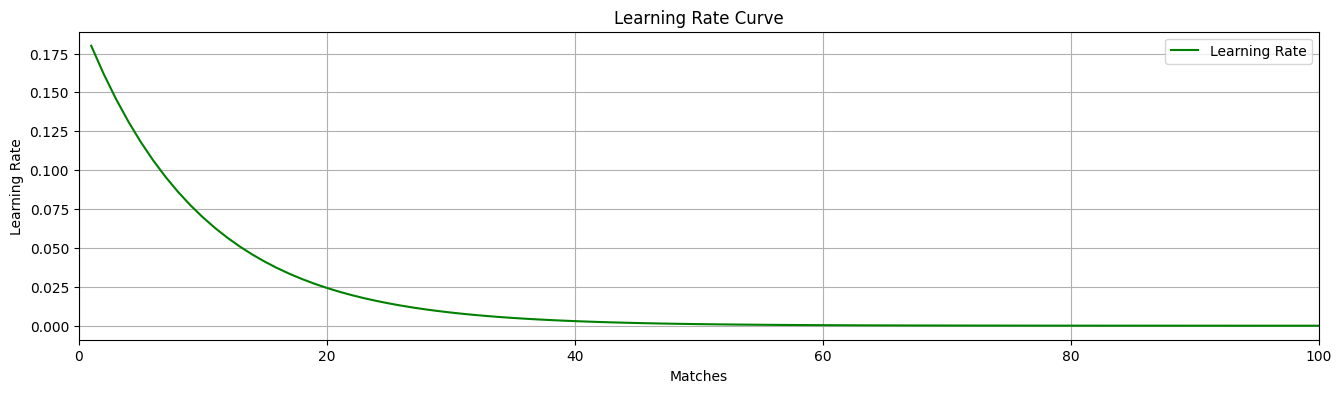

In [ ]:
def plot_learning_rate(learning_rates, title="Learning Rate Curve", xlabel="Matches", ylabel="Learning Rate"):
    """
    Plot the learning rate over time.

    Parameters:
    - learning_rates (list): List of learning rates over time.
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    """
    matches = list(range(1, len(learning_rates) + 1))

    plt.figure(figsize=(16, 4))
    plt.plot(matches, learning_rates, label='Learning Rate', color='g')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0, 100) # for better visualize the graph
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_rate(lrs)

elbow point: 20 matches, lr = 0.025

________________________________________________________________________________________________

## Q Learning

In [22]:
from random import choice
# let's play tic tac toe with the magic square knowledge background
import numpy as np
from itertools import combinations
from collections import namedtuple, defaultdict
from copy import deepcopy
from tqdm.auto import tqdm

In [23]:
import random
# let's play tic tac toe with the magic square knowledge background
import numpy as np
from itertools import combinations
from collections import namedtuple, defaultdict
from copy import deepcopy
from tqdm.auto import tqdm

State = namedtuple('State', ['x', 'o'])

MAGIC = [2, 7, 6,
         9, 5, 1,
         4, 3, 8]

def win(elements):
    # check if the elements are winning
    # if any of the combinations of 3 numbers taken randomly from 1 to 9 is equal to 15
    return any(sum(c) == 15 for c in combinations(elements, 3))

def state_value(pos: State):
    # evaluate state: +1 first player wins
    if win(pos.x):
      return 1
    elif win(pos.o):
      return 0
    else:
      return -1

def print_board(pos):
    for row in range(3):
      for column in range(3):
        i = row * 3 + column
        if MAGIC[i] in pos.x:
          print('x', end='')
        if MAGIC[i] in pos.o:
          print('o', end='')
        else:
          print('_', end='')
      print()
    print()

In [24]:
class RandomPlayer:
  def __init__(self, x_or_o):
      self.x_or_o = x_or_o
      self.wins = 0
      self.value_dictionary = defaultdict(float)
      self.alpha = 0.1
      self.decay_gamma = 0.9

  def move(self, available, state = None):
      return random.choice(list(available))

  def feedReward(self, state, reward, mov):
      hashable_state = (frozenset(state.x), frozenset(state.o))
      self.value_dictionary[(hashable_state, mov)] += self.alpha * (self.decay_gamma * reward - self.value_dictionary[(hashable_state, mov)])
      r = self.value_dictionary[(hashable_state, mov)]
      return r

In [25]:
class QLearningAgent:
    def __init__(self, x_or_o, epsilon, alpha, gamma):
        # Q-values: {(state, mov): value}
        self.x_or_o = x_or_o
        # self.q_values = defaultdict(float)
        self.q_values = {}
        self.epsilon = epsilon  # balance between exploration and exploitation
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.wins = 0

    def do_it_random(self, available, state):
        move = random.choice(list(available))
        current_state = deepcopy(state)
        current_state.x.add(move)
        # if (frozenset(state.x), frozenset(state.o)) not in self.value_dictionary.keys():
        self.q_values[(frozenset(state.x), frozenset(state.o))] = self.epsilon
        return move

    def get_q_value(self, state, mov):
        hashable_state = (frozenset(state.x), frozenset(state.o))
        # return self.q_values[(hashable_state, mov)]
        return self.q_values.get((hashable_state, mov), 0.0)

    def move(self, available, state):
        best_move = None
        if random.random() <= self.epsilon:
          # do a random move
          move = self.do_it_random(available, state)
          best_move = move
        else:
            # exploitation: choose the move with the highest value of q
            if (frozenset(state.x), frozenset(state.o)) in self.q_values.keys():
                q_values = [self.get_q_value(state, move) for move in available]
                # hashable_state = (frozenset(state.x), frozenset(state.o))
                # q_values = [self.q_values[(hashable_state, move)]  for move in available]
                max_q_value = max(q_values)
                best_moves = [move for move, q_value in zip(available, q_values) if q_value == max_q_value]
                best_move = random.choice(best_moves)
            else:
                self.q_values[(frozenset(state.x), frozenset(state.o))] = 0.0
                best_move = choice(list(available))

        return best_move

    def update_q_value(self, state, mov, reward, next_state):
        max_next_q_value = max(self.get_q_value(next_state, next_move) for next_move in range(1, 10))
        updated_q_value = (1 - self.alpha) * self.get_q_value(state, mov) + self.alpha * (reward + self.gamma * max_next_q_value)
        hashable_state = (frozenset(state.x), frozenset(state.o))

        self.q_values[(hashable_state, mov)] = updated_q_value

    def return_lr(self, state, reward, mov):
        hashable_state = (frozenset(state.x), frozenset(state.o))
        self.q_values[(hashable_state, mov)] += self.alpha * (self.decay_gamma * reward - self.q_values[(hashable_state, mov)])
        r = self.q_values[(hashable_state, mov)]
        self.alpha *= self.decay_gamma
        return self.alpha

    def feedReward(self, state, reward, mov):
        hashable_state = (frozenset(state.x), frozenset(state.o))
        if hashable_state in self.q_values.keys():
            self.q_values[(hashable_state, mov)] += self.alpha * (self.decay_gamma * reward - self.q_values[(hashable_state, mov)])
            r = self.q_values[(hashable_state, mov)]
        else:
            # r = -0.5
            r = - self.epsilon
        return r

def game(player1, player2):
    trajectory = list()
    state = State(set(), set())
    available = set(range(1, 9+1))

    players = [player1, player2]
    first_player = random.choice([0, 1])
    while available:
      current_player = players[first_player]

      move = current_player.move(list(available), state)

      # x = random.choice(list(available))
      if current_player.x_or_o == 1: # move = put a x
        state.x.add(move)
        trajectory.append(deepcopy(state))
        available.remove(move)
        if win(state.x) or not available:
          # current_player.wins += 1
          player2.wins += 1
          break

      else: # move = put a o
        # o = random.choice(list(available))
        state.o.add(move)
        trajectory.append(deepcopy(state))
        available.remove(move)
        if win(state.o):
          # current_player.wins += 1
          player1.wins += 1
          break

      first_player = 1 - first_player # if player 0 started, now it's the turn of player 1

    return trajectory, move


def give_reward(state, player1, player2, move):
    # result = win(state.x)
    if win(state.x): # x won
        player1.feedReward(state, 1, move)
        fr = player2.feedReward(state, -0.5, move)
    elif win(state.o): # o won
        player1.feedReward(state, -0.5, move)
        fr =  player2.feedReward(state, 1, move)
    else: # nobody won
        player1.feedReward(state, 0.1, move)
        fr = player2.feedReward(state, 0.1, move)
    return fr


# player1 = RandomPlayer(0) # o
# player2 = QLearningAgent(1) # x
# epsilon = 0.1

def train(player1, player2, matches = 10_000):
    for _ in range(matches):
        trajectory, mov = game(player1, player2)
        # print(trajectory)
        reward = give_reward(trajectory[-1], player1, player2, mov)
        # final_reward = state_value(trajectory[-1])

        for state in trajectory:
            player2.update_q_value(state, mov, -reward, trajectory[-1])

    win_percentage = player2.wins / matches * 100
    print(f'The Q-learning agent wins {win_percentage}% of the times in training.')


def test(player1, player2, test_matches=1000):
    player2.wins = 0

    for _ in range(test_matches):
        trajectory, mov = game(player1, player2)

    win_percentage = player2.wins / test_matches * 100
    print(f'The Q-learning agent wins {round(win_percentage, 2)}% of the times in testing.')
    print(f'\n')

epsilons = [0.1, 0.3]
alphas = [0.2, 0.8]
gammas = [0.3, 0.9]

if __name__ == "__main__":
    for eps in epsilons:
      for alpha in alphas:
        for gamma in gammas:
          player1 = RandomPlayer(0)
          player2 = QLearningAgent(1, eps, alpha, gamma)
          print(f'TRYING WITH EPSILON = {eps}, ALPHA = {alpha}, GAMMA = {gamma}')
          train(player1, player2)
          test(player1, player2)

TRYING WITH EPSILON = 0.1, ALPHA = 0.2, GAMMA = 0.3
The Q-learning agent wins 79.27% of the times in training.
The Q-learning agent wins 83.0% of the times in testing.


TRYING WITH EPSILON = 0.1, ALPHA = 0.2, GAMMA = 0.9
The Q-learning agent wins 78.96% of the times in training.
The Q-learning agent wins 82.5% of the times in testing.


TRYING WITH EPSILON = 0.1, ALPHA = 0.8, GAMMA = 0.3
The Q-learning agent wins 74.63% of the times in training.
The Q-learning agent wins 79.7% of the times in testing.


TRYING WITH EPSILON = 0.1, ALPHA = 0.8, GAMMA = 0.9
The Q-learning agent wins 72.86% of the times in training.
The Q-learning agent wins 81.3% of the times in testing.


TRYING WITH EPSILON = 0.3, ALPHA = 0.2, GAMMA = 0.3
The Q-learning agent wins 71.69% of the times in training.
The Q-learning agent wins 78.8% of the times in testing.


TRYING WITH EPSILON = 0.3, ALPHA = 0.2, GAMMA = 0.9
The Q-learning agent wins 71.61999999999999% of the times in training.
The Q-learning agent wins 7

After the previous analyses, we can notice that low values of the exploration-exploitation balance (epsilon), the learning rate (alpha) and the discount factor (gamma) let the agent win 83% of the times in testing  in the best case. A little bit lower percentage is seen with higher values of the three rates.

_________________